In [1]:
#from google.colab import drive
#drive.mount ('/content/drive')

In [3]:
import numpy as np
import matplotlib as matplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn import (
    linear_model, metrics, pipeline, preprocessing, model_selection
)

from sklearn.preprocessing import scale, LabelEncoder
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

#from statsmodels.formula.api import SurvfuncRight

#!pip install lifelines
from lifelines import CoxPHFitter

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

import sklearn.linear_model as skl_lm

from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
raw_data = pd.read_csv("compas-scores-two-years.csv")
print(raw_data.shape)
raw_data.columns

(7214, 53)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [ ]:
raw_data.head()

In [ ]:
raw_data.isna().sum()

Short comparison to other CSVs

In [5]:
parsed_data = pd.read_csv("cox-parsed.csv")
print(parsed_data.shape)
parsed_data.columns 

(13419, 52)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

how is this dataset diffrent: number of rows is bigger (names double if diffrent), but columns are the same

In [ ]:
parsed_data.head()

# Data Cleaning

In [6]:
df = raw_data.loc[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != "O") &
    (raw_data['score_text'] != "N/A")
]
len(df)

6172

# Exploratory Analysis

In [ ]:
df['race'].value_counts()

In [ ]:
# Race by Score Text
pd.crosstab(df['score_text'],df['race'])

In [ ]:
score_text_by_race = df.groupby(['race','score_text'], sort = True)['id'].size()
score_text_by_race.unstack().plot(
    kind = "barh", 
    title = "Score Text by Race",
    ylabel = "Score Text",
    xlabel = "Race",
    figsize = (8,4),
    stacked = True
)

In [ ]:
df_three = df.loc[df['race'].isin(["African-American","Caucasian","Hispanic"])]

In [ ]:
#calculate the total and proportions of score texts in each race group
score_text_by_race_prop= df_three.groupby(['race', 'score_text']).agg({'score_text': 'count'})
score_text_by_race_prop['prop'] = score_text_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))
score_text_by_race_prop

In [ ]:
df_three.groupby('race')['decile_score'].mean()

# Distribution of decile scores

In [ ]:
sns.countplot(
    data = df_three,
    x = 'decile_score',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

# COMPAS Score Prediction
## Linear Regression Model

In [ ]:
features = pd.concat(
    [pd.get_dummies(df_three.age_cat, prefix='age'),
     pd.get_dummies(df_three.sex, prefix='sex'),
     pd.get_dummies(df_three.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     df.priors_count],
    axis=1)

# drop one less dummy variable
features.drop(['age_25 - 45', 'sex_Female', 'degree_M'], axis=1, inplace=True)

# predict the Decile Score
target = df_three.decile_score

In [ ]:
target.head()

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
    

## Lasso

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.25, random_state = 3)

In [ ]:
alphas = 10**np.linspace(10,-2,1000)*0.5 #why?, why not make 0.95 in the first place?
#print(alphas)
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html

In [ ]:
# Lasso Model
# find the best alpha
lasso = linear_model.LassoCV(alphas = alphas, cv = 10, max_iter = 100000) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
lasso_cv = lasso.fit(X_train,y_train)

lasso_predict = lasso_cv.predict(X_test)
lasso_mse = metrics.mean_squared_error(y_test, lasso_predict)
lasso_mse 

In [ ]:
lasso_cv.alpha_

In [ ]:
#accuracy of lasso
lasso_MAPE = MAPE(y_test,lasso_predict) #(Mean Absolute Percentage Error) 
print("MAPE value lasso Regression: ",lasso_MAPE)
lasso_Accuracy = 100 - lasso_MAPE
print('Accuracy of lasso Regression: {:0.2f}%.'.format(lasso_Accuracy))

In [ ]:
#why both? do I see which variables are excluded by lasso in this case?
#Accuracy of Ridge is slightly better

## Ridge

In [ ]:
#with alpha from lasso

#TO DO there is also a ridge cv function that should be used for alpha here
ridge = linear_model.Ridge(alpha = lasso_cv.alpha_, normalize = True) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
ridge_model = ridge.fit(X_train, y_train) #that's with alpha=1.0

ridge_predict = ridge_model.predict(X_test)
ridge_mse = metrics.mean_squared_error(y_test, ridge_predict)
ridge_mse 

In [ ]:
#ridge scheint nur mit einem alpha zu gehen und nicht mit alphas?

In [ ]:
Ridge_MAPE = MAPE(y_test,ridge_predict)
print("MAPE value: ",Ridge_MAPE)
Accuracy = 100 - Ridge_MAPE
print('Accuracy of Ridge Regression: {:0.2f}%.'.format(Accuracy))

#source: https://www.askpython.com/python/examples/ridge-regression
#also interesting source: https://www.statology.org/ridge-regression-in-python/

In [ ]:
'''clf = DecisionTreeClassifier(random_state=42)

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf, X_test, y_test, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

#source: https://www.w3schools.com/python/python_ml_cross_validation.asp'''

## Interpretation of MSE

Advantages of using MSE
*  Easy to calculate in Python
*  Simple to understand calculation for end users
*  Designed to punish large errors

Disadvantages of using MSE
*  Error value not given in terms of the target
*  Difficult to interpret
*  Not comparable across use cases

What is a good MSE value?
The closer your MSE value is to 0, the more accurate your model is. However, there is no 'good' value for MSE. It is an absolute value which is unique to each dataset and can only be used to say whether the model has become more or less accurate than a previous run.

Can MSE be used to compare models?
MSE cannot be used to compare different models from different datasets as it’s an absolute value that is only relevant to that given dataset. If you need to compare models across different datasets then it would be best to use percentage metrics such as MAPE.

source: https://stephenallwright.com/good-mse-value/

## Interpretation of MAPE

MAPE (Mean Absolute Percentage Error) is a common regression machine learning metric, but it can be confusing to know what a good score actually is. In this post, I explain what MAPE is, what a good score is, and answer some common questions that people have.

What is MAPE?
Mean Absolute Percentage Error (MAPE) is the mean of all absolute percentage errors between the predicted and actual values.

It is a popular metric to use as it returns the error as a percentage, making it both easy for end users to understand and simple to compare model accuracy across use cases and datasets.

Positives of using MAPE as a metric
*  Easy for end users to understand as the error is a percentage
*  Possible to compare model accuracy across datasets and use cases
*  Easily implemented in Python

Negatives of using MAPE as a metric
*  Not possible to use when actual values can be at or close to zero

When to use MAPE?
MAPE should be used when either communicating results to end users is important or when you need to be able to compare your results with other models. It shouldn’t be used when you have actual values that are close to or at zero due to the division by zero error.

source: https://stephenallwright.com/good-mape-score/

# Reproduce COMPAS analysis

*   Distribution of COMPAS score among whtites and blacks (plot) & compare with Distribution of real recidivism among whites and blacks (plot)
*   Most predictive factors in logistic model (with controlling for other factors) for score

Application of Survival Function (It looks at Time to event (in this case 2 years):

*   Cox proportional hazard model (https://towardsdatascience.com/the-cox-proportional-hazards-model-35e60e554d8f) 
·	Coefficients
·	Interaction term
·	Contigency table (FP / FN rates) among all, whites and blacks

*   Kaplan Meier survival plot „shows the probability of an event at a respective time interval“ (https://www.mygreatlearning.com/blog/kaplan-meier-curve-explained/)



In [19]:
df_binary = df.loc[df['race'].isin(["African-American","Caucasian"])]

In [ ]:
df_binary.head()

### Distribution of COMPAS score among whtites and blacks (plot) & compare with Distribution of real recidivism among whites and blacks (plot)

In [ ]:
#calculate the total and proportions of decile scores in each race group
decile_score_by_race_prop= df_binary.groupby(['race', 'decile_score']).agg({'decile_score': 'count'})
decile_score_by_race_prop['prop'] = decile_score_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

In [ ]:
is_recid_by_race_prop= df_binary.groupby(['race', 'is_recid']).agg({'decile_score': 'count'})
is_recid_by_race_prop['prop'] = is_recid_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

In [ ]:
sns.countplot(
    data = df_binary,
    x = 'decile_score',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

In [ ]:
sns.countplot(
    data = df_binary,
    x = 'is_recid',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of recidivism by Race')
plt.xlabel('Recidivism')
plt.ylabel('Count')

### Most predictive factors in logistic model (with controlling for other factors) for score

In [7]:
#medium and high are high, low stays low

df['score_text_binary'] = df['score_text'].replace(['Medium'], 'High')

In [8]:
#make numbers
df['score_text_binary']= df['score_text_binary'].replace(['High'], 1)
df['score_text_binary']= df['score_text_binary'].replace(['Low'], 0)

In [ ]:
#First logistic regression
est = smf.logit('score_text_binary ~ C(age_cat) + C(race) + C(sex) + priors_count + C(c_charge_degree) + two_year_recid', df).fit()
print(est.summary())

In [ ]:
#releveling to get the intercept we want
X = pd.concat(
    [pd.get_dummies(df.age_cat, prefix='age'),
     pd.get_dummies(df.sex, prefix='sex'),
     pd.get_dummies(df.race, prefix='race'),
     pd.get_dummies(df.c_charge_degree, prefix='c_charge_degree'),
     df.priors_count, df.two_year_recid],
    axis=1)
X.head()


In [ ]:
# drop one less dummy variable
X.drop(['age_25 - 45', 'sex_Male', 'race_Caucasian'], axis=1, inplace=True)


In [ ]:
y = df.score_text_binary

In [ ]:
#rearranging the columns:
cols = X.columns.tolist()
cols

In [ ]:
skl_lm.LogisticRegression()

In [ ]:
est2 = smf.logit('y ~ X', X).fit()
print(est2.summary().tables[1]) 

In [ ]:
#predict score text

est = smf.logit('y ~ X', df).fit()
print(est.summary().tables[1]) 

In [ ]:
X_train_log, X_test_log, y_train_log, y_test_log = model_selection.train_test_split(X, y,test_size = 0.3, random_state = 3)

In [ ]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train_log,y_train_log)

print('columnnames: ',clf.feature_names_in_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_) #intercept matches somehow

#why is it diffrent numbers than logit?

In [ ]:
#TO DO remember that charge degree should go into the intercept
# why are two columns with nan values in the logit regression (could be the charge degree)?

### Most predictive factors in logistic model (with controlling for other factors) for recidivism

In [ ]:
X_recid = pd.concat(
    [pd.get_dummies(df.age_cat, prefix='age'),
     pd.get_dummies(df.sex, prefix='sex'),
     pd.get_dummies(df.race, prefix='race'),
     pd.get_dummies(df.c_charge_degree, prefix='c_charge_degree'),
     df.priors_count],
    axis=1)

# Reproduce Northpointe's rebuttal
AUC Results in Sample A
Sample A consists of pretrial defendants with complete case
records who have at least two years of follow-up time. The PP authors use
Sample A to fit reverse logistic regressions predicting the“Not Low”Risk Level.
Subsets of Sample A are used for tests of the GRRS (n=6,172) and the VRRS
(n=4,020). (p.4 and 16 Northpointe)

In [ ]:
# Convert categorical features to numeric levels
'''for feature in df.columns:
    if df[feature].dtype=="object":
      #print(feature)
      le = LabelEncoder()
      le.fit(df.columns)
      df[feature] = le.fit_transform(df[feature].astype(str)) #le.fit_transform(df_train[feature].astype(str))

print(df.head())'''

In [ ]:
'''X2= df[['age_cat','race', 'sex', 'priors_count','c_charge_degree', 'two_year_recid']]
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X2, y, test_size = 0.3, random_state = 3)'''

In [ ]:
'''clf2 = skl_lm.LogisticRegression(solver='newton-cg')
clf2.fit(X_train2,y_train2)

y_pred2 = clf.predict_proba(X_test2) 
y_pred_prob2 = y_pred2[:,1]


#ROC
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_prob2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

#AUC
print('The total AUC is ', roc_auc_score(y_test2, y_pred_prob2))'''

In [ ]:
'''y_pred = clf.predict_proba(X_test_log) 
y_pred_prob = y_pred[:,1]

#ROC
fpr, tpr, thresholds = roc_curve(y_test_log, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

#AUC
print('The total AUC is ', roc_auc_score(y_test_log, y_pred_prob))'''

##AUC for multiclass taking the idea from https://allendowney.github.io/RecidivismCaseStudy/02_calibration.html

In [9]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


In [10]:
download('https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/' +
         'master/utils.py')

Downloaded utils.py


In [11]:
from utils import decorate
from utils import make_matrix
from utils import compute_metrics
from utils import error_rates

In [12]:
def calibration_curve(df):
    """Fraction in each risk group charged with another crime.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

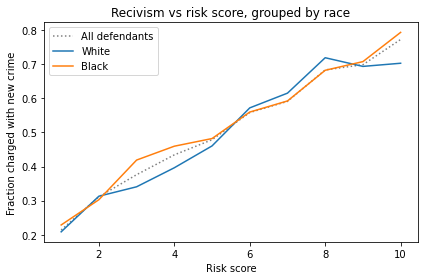

In [13]:
#Washinton post!!!
cal_all = calibration_curve(raw_data)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

white = (raw_data['race'] == 'Caucasian')
cal_white = calibration_curve(raw_data[white])
cal_white.plot(label='White')

black = (raw_data['race'] == 'African-American')
cal_black = calibration_curve(raw_data[black])
cal_black.plot(label='Black')

decorate(xlabel='Risk score',
         ylabel='Fraction charged with new crime',
         title='Recivism vs risk score, grouped by race')

###Matrices and Metrics

In [ ]:
matrix_white = make_matrix(raw_data[white])
matrix_white

In [ ]:
matrix_black = make_matrix(raw_data[black])
matrix_black

In [ ]:
metrics_white = compute_metrics(matrix_white, 
                                'White defendants')
metrics_white

In [ ]:
metrics_black = compute_metrics(matrix_black, 
                                'Black defendants')
metrics_black

###What Would It Take?
Suppose we want to fix COMPAS so that predictive values are the same for black and white defendants. We could do that by using different thresholds for the two groups.

In this section, we’ll figure out what it would take to re-calibrate COMPAS; then we’ll see what effect that would have on predictive values.

In [ ]:
def sweep_threshold(cp):
    """Sweep a range of threshold and compute accuracy metrics.
    
    cp: DataFrame of COMPAS data
    
    returns: DataFrame with one row for each threshold and
             one column for each metric
    """
    index = range(0, 11)
    columns = ['FPR', 'FNR', 'PPV', 'NPV', 'Prevalence']
    table = pd.DataFrame(index=index, columns=columns, dtype=float) 

    for threshold in index:
        m = make_matrix(cp, threshold)
        metrics = compute_metrics(m)
        table.loc[threshold] = metrics['Percent']
        
    return table

# Reproduce Washington Post 1 analysis

In [14]:
import plotly.express as px

In [52]:
df_black = raw_data.loc[raw_data['race'].isin(["African-American"])]
df_black.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
11,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,...,4,Low,2013-10-03,2013-10-03,2013-10-07,3,4,128,1,1
13,18,jarrod turbe,jarrod,turbe,2013-10-09,Male,1974-12-02,41,25 - 45,African-American,...,2,Low,2013-10-09,2013-10-08,2013-10-09,0,0,905,0,0


In [53]:
df_white = raw_data.loc[raw_data['race'].isin(["Caucasian"])]
df_white.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,5,Medium,2013-11-04,2015-01-06,2015-01-07,1,0,428,1,1
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
12,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,...,1,Low,2013-01-01,2013-01-01,2013-01-02,0,1,1186,0,0


In [100]:
df_white['score_text'] = raw_data['score_text'].replace(['Medium'], 'High')
df_white_recid = df_white.loc[df_white['is_recid'].isin([1])]
df_white_nonrecid = df_white.loc[df_white['is_recid'].isin([0])]
df_black['score_text'] = raw_data['score_text'].replace(['Medium'], 'High')
df_black_recid = df_black.loc[df_black['is_recid'].isin([1])]
df_black_nonrecid = df_black.loc[df_black['is_recid'].isin([0])]

Text(0, 0.5, 'Count')

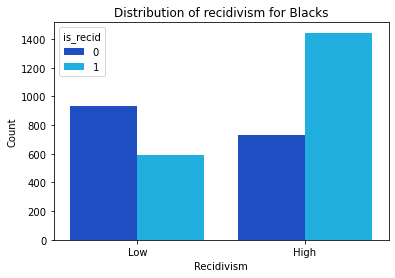

In [93]:
sns.countplot(
    data = df_black,
    x = 'score_text',
    hue = 'is_recid',
    palette = ["#0343DF","#00bfff"]
)
plt.title('Distribution of recidivism for Blacks')
plt.xlabel('Recidivism')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

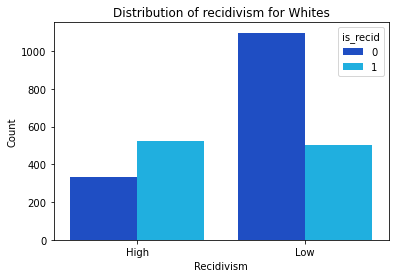

In [94]:
sns.countplot(
    data = df_white,
    x = 'score_text',
    hue = 'is_recid',
    palette = ["#0343DF","#00bfff"]
    
)


plt.title('Distribution of recidivism for Whites')
plt.xlabel('Recidivism')
plt.ylabel('Count')

<function matplotlib.pyplot.show(close=None, block=None)>

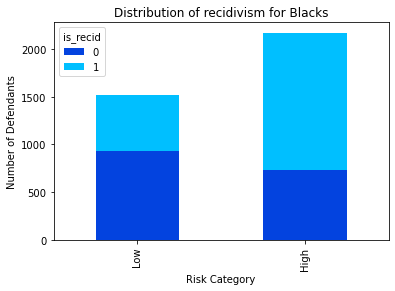

In [115]:
## trying with 2 subplots for stacking
df_plot = df_black.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
ax = df_plot.plot(
    kind='bar', 
    stacked=True,
    title='Distribution of recidivism for Blacks',
    color=["#0343DF","#00bfff"])
plt.gca().invert_xaxis()
ax.set_xlabel("Risk Category")
ax.set_ylabel("Number of Defendants")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

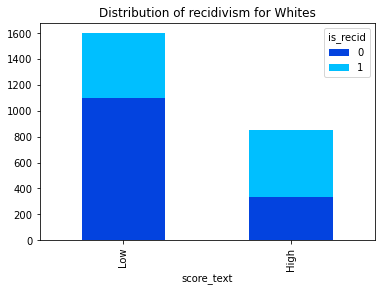

In [116]:
df_plot = df_white.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    title='Distribution of recidivism for Whites',
    color=["#0343DF","#00bfff"])
plt.gca().invert_xaxis()
ax.set_xlabel("Risk Category")
ax.set_ylabel("Number of Defendants")
plt.show

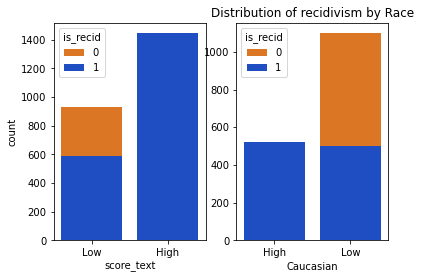

In [67]:
fig, (ax1, ax2) = plt.subplots(1,2)

sns.countplot(
    data = df_black,
    x = 'score_text',
    hue = 'is_recid',
    palette = ["#F97306","#0343DF","#00FF00"],
    dodge=False,
    ax=ax1
)

plt.title('Distribution of recidivism by Race')
plt.xlabel('African-American')
plt.ylabel('')

sns.countplot(
    data = df_white,
    x = 'score_text',
    hue = 'is_recid',
    palette = ["#F97306","#0343DF","#00FF00"],
    dodge=False,
    ax=ax2
)

plt.title('Distribution of recidivism by Race')
plt.xlabel('Caucasian')
plt.ylabel('')

fig.show()


In [65]:
df_white['is_recid']

6       1
8       0
9       1
10      0
12      0
       ..
7192    0
7194    1
7199    0
7205    1
7206    1
Name: is_recid, Length: 2454, dtype: int64

# Directly / indirectly Model recidivism / Tree based model for ?


directly(classification) --> random forest?
*  predict recidivism
*  predict violent recidivism

indirectly (regression)
*  predict COMPAS scores for recidivism
*  predict COMPAS scores for violent recidivism


# Explore connections between local and global explanations from machine learning model with multiple linear regression

# 1 or more questions from the following:

1. Is there a single correct definition of fairness ? Are multiple types of fairness compatible ?
2. Are interpretable models just as accurate as black box machine learning models for predicting recidivism ?
Can complex models be as transparent as simple ones ? How do I communicate nonlinear dependencies ?
3. How do I explain a single prediction, i.e. how do I decompose it into feature driven components ? What
would be useful global feature attribution methods ?
4. How does the "base rate" affect the tradeoffs ?
5. How can I find relevant interactions ?
6. Counterfactuals: what extra value do they bring and what assumptions are made ?


# Are the COMPAS risk scales racially biased against blacks?


"Particular characteristics of non-black defendants in Broward County, Florida are the reason why some of the previous analyses found COMPAS biased" (stated as an assumption in file:///C:/Users/joana/Documents/Nextcloud/03%20Karriere/2022%20WS%2023%20BIPM%20HWR/1%20-%20Data%20Science/project/reading/Chapter%2010%20Story%20COMPAS_%20recidivism%20reloaded%20_%20XAI%20Stories.pdf page 16)

Check Ceteris Paribus (which freezes all othe factors) and then it's still biased for African Americans (same, page 20)



could they controll for race (interrelating with age and number for arrests for example)?

### Is the Articel / model of COMPAS good?

They should have done a regression with only whites and blacks not all --> numbers change

# Check in the end whether:
